In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import bs4
import urllib
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
%matplotlib inline

In [2]:
# setup some cutoff values we'll use in the analysis
velCutoffUpper = 2000.
velCutoffLower = 0.
numPointsCutoffMLTMLAT = 150
mlatCutOffUpper = 70.

In [3]:
# READ Dst and AE data
inpDstFile = "../data/dst_out_file.csv"
dstDF = pandas.read_csv(inpDstFile, sep=' ',\
                infer_datetime_format=True,\
                        parse_dates=["dst_date"])
dstDF = dstDF[ (dstDF["dst_date"] > datetime.datetime(2010,12,31)) &\
             (dstDF["dst_date"] < datetime.datetime(2015,1,1))].reset_index(drop=True)
dstDF = dstDF[ dstDF["dst_index"] <= 10. ].reset_index(drop=True)
dstDF["dtStr"] = dstDF["dst_date"].apply(lambda x: x.strftime('%Y%m%d'))
dstDF["hour"] = dstDF["dst_date"].apply(lambda x: x.strftime('%H'))
# Aur Inds
aurDF = pandas.read_csv( "../data/aur_processed.txt", sep=' ' )
aurDF["date"] = pandas.to_datetime(aurDF["datetimeStr"], format='%Y%m%d-%H-%M')
aurDF["hour"] = aurDF["date"].apply(lambda x: x.strftime('%H'))
aurDF["minute"] = aurDF["date"].apply(lambda x: x.strftime('%M'))
aurDF["dtStr"] = aurDF["date"].apply(lambda x: x.strftime('%Y%m%d'))

In [4]:
#### In this block we load Velocity data ####
#### In this block we load Velocity data ####
#### In this block we load Velocity data ####
# a helper function to convert seperate date
# and time strings to datetime objects  
fitVelFile = "../data/fitres.csv"
inpColNames = ["azim", "azimStd", "delMLT", "endPtMLAT",\
               "endPtNormMLT","goodFit", "MLAT", "normMLT",\
               "vSaps", "velSTD", "date"]
# velsDataDF = pandas.read_csv(fitVelFile, sep=' ', header=None)
# velsDataDF.columns = inpColNames
velsDataDF = pandas.read_csv(fitVelFile, sep=' ',\
                             header=None, names=inpColNames,\
                            infer_datetime_format=True,\
                            parse_dates=["date"])
velsDataDF.head()
velsDataDF["dtStr"] = velsDataDF["date"].apply(lambda x: x.strftime('%Y%m%d'))
# Discard unwanted values
# We'll only consider those velocities 
# which lie between 0 and 2500 m/s
# and located below 70 MLAT
velsDataDF = velsDataDF[ (velsDataDF["vSaps"] > velCutoffLower) \
                        & (velsDataDF["vSaps"] < velCutoffUpper)\
                       ].reset_index(drop=True)
velsDataDF = velsDataDF[ velsDataDF["MLAT"] < mlatCutOffUpper ].reset_index(drop=True)
velsDataDF["hour"] = velsDataDF["date"].apply(lambda x: x.strftime('%H'))
velsDataDF["minute"] = velsDataDF["date"].apply(lambda x: x.strftime('%M'))
# Now merge the dst and velocity DFs
velsDataDF = pandas.merge( velsDataDF, dstDF,\
                          on=["dtStr", "hour"], how='inner' )
# We generally work with Dst bins, set them up
# add dst_bins
dstBins = [ -150, -75, -50, -25, -10, 10 ]
velsDataDF = pandas.concat( [ velsDataDF, \
                    pandas.cut( velsDataDF["dst_index"], \
                               bins=dstBins ) ], axis=1 )
# Also merge with aurDF
# print "pre merge shape-->", velsDataDF.shape
velsDataDF = pandas.merge( velsDataDF, aurDF,\
                         on=["dtStr", "hour", "minute"], how='inner')

velsDataDF.to_csv("../data/processed-vels-geomag.txt", sep=' ', index=False)
velsDataDF.head()
#### In this block we load Velocity data ####
#### In this block we load Velocity data ####
#### In this block we load Velocity data ####

,azim,azimStd,delMLT,endPtMLAT,endPtNormMLT,goodFit,MLAT,normMLT,vSaps,velSTD,...,minute,dst_date,dst_index,dst_index,datetimeStr,AE,AL,AO,AU,date_y
0,-6.932417,3.615488,0.5,NaN,NaN,True,64.0,0.0,419.985262,56.034926,...,16,2012-10-23 07:00:00,4.0,"(-10, 10]",20121023-07-16,73,-42,-6,31,2012-10-23 07:16:00
1,-6.932417,NaN,NaN,63.64,-1.15,False,63.5,0.0,1158.030754,NaN,...,16,2012-10-23 07:00:00,4.0,"(-10, 10]",20121023-07-16,73,-42,-6,31,2012-10-23 07:16:00
2,-3.387108,2.012791,0.5,NaN,NaN,True,64.0,0.0,400.780823,28.458519,...,24,2012-10-23 07:00:00,4.0,"(-10, 10]",20121023-07-24,121,-98,-38,23,2012-10-23 07:24:00
3,-3.387108,NaN,NaN,63.05,-0.90,False,63.0,0.0,902.535876,NaN,...,24,2012-10-23 07:00:00,4.0,"(-10, 10]",20121023-07-24,121,-98,-38,23,2012-10-23 07:24:00
4,-3.387108,NaN,NaN,63.56,-0.98,False,63.5,0.0,985.062779,NaN,...,24,2012-10-23 07:00:00,4.0,"(-10, 10]",20121023-07-24,121,-98,-38,23,2012-10-23 07:24:00


In [5]:
# Filter out some values where number of datapoints are pretty low.
countDF = velsDataDF.groupby([ "normMLT", "MLAT" ]).size().reset_index()
countDF.columns = [ "normMLT", "MLAT", "count" ]
# Choose only columns which have atleast 100 points
countDF = countDF[ countDF["count"] >= numPointsCutoffMLTMLAT ].reset_index(drop=True)
# Merge with velsDataDF to filter out unwanted values
velsDataDF = pandas.merge( velsDataDF, countDF,\
                          on=["normMLT", "MLAT"], how='inner' )
velsDataDF.head()

,azim,azimStd,delMLT,endPtMLAT,endPtNormMLT,goodFit,MLAT,normMLT,vSaps,velSTD,...,dst_date,dst_index,dst_index,datetimeStr,AE,AL,AO,AU,date_y,count
0,-3.387108,NaN,NaN,63.05,-0.90,False,63.0,0.0,902.535876,NaN,...,2012-10-23 07:00:00,4.0,"(-10, 10]",20121023-07-24,121,-98,-38,23,2012-10-23 07:24:00,284
1,-3.516834,NaN,NaN,63.04,-0.66,False,63.0,0.0,659.606637,NaN,...,2012-10-23 07:00:00,4.0,"(-10, 10]",20121023-07-26,116,-100,-42,16,2012-10-23 07:26:00,284
2,-9.533716,NaN,NaN,63.12,-0.69,False,63.0,0.0,704.274601,NaN,...,2012-10-23 07:00:00,4.0,"(-10, 10]",20121023-07-28,106,-87,-34,19,2012-10-23 07:28:00,284
3,-18.011539,3.652241,1.0,NaN,NaN,True,63.0,0.0,441.631334,57.540267,...,2011-09-20 06:00:00,-24.0,"(-25, -10]",20110920-06-08,110,-52,3,58,2011-09-20 06:08:00,284
4,-18.011539,3.652241,1.0,NaN,NaN,True,63.0,0.0,441.631334,57.540267,...,2011-09-20 06:00:00,-24.0,"(-25, -10]",20110920-06-08,110,-52,3,58,2011-09-20 06:08:00,284


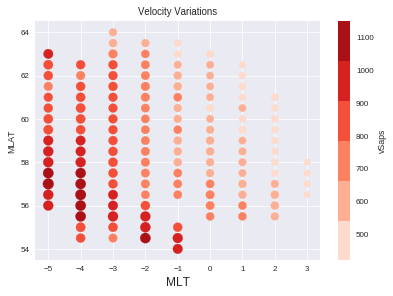

In [6]:
# We'll now divide data into MLT/MLAT bins and get some stats
mltMlatMeanDF = velsDataDF.groupby( [ "normMLT", "MLAT" ] ).mean().reset_index()
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
mltMlatMeanDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=mltMlatMeanDF["vSaps"]/10, cmap=seaMap, ax=ax)
ax.set_ylabel("MLAT")
ax.set_xlabel("MLT", fontsize=12)
ax.set_title( "Velocity Variations" )
plt.savefig("../figs/meanVelMLATMLT.pdf",bbox_inches='tight')

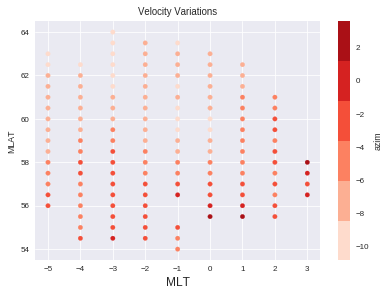

In [7]:
mltMlatMeanDF = velsDataDF.groupby( [ "normMLT", "MLAT" ] ).mean().reset_index()
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
mltMlatMeanDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='azim',
              s=20, cmap=seaMap, ax=ax)
ax.set_ylabel("MLAT")
ax.set_xlabel("MLT", fontsize=12)
ax.set_title( "Velocity Variations" )
plt.savefig("../figs/meanAzimMLATMLT.pdf",bbox_inches='tight')

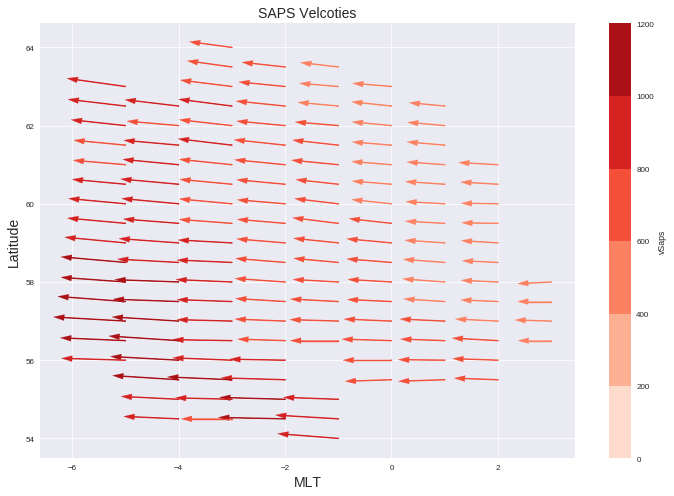

In [8]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

# Not only velocity magnitudes we'd also 
# like to plot azimuths!
# get the end points of vectors
mltMlatMeanDF["plot_MLATEnd"] = numpy.round( (mltMlatMeanDF["vSaps"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*mltMlatMeanDF["azim"]) ) +\
                                mltMlatMeanDF["MLAT"], 2)
mltMlatMeanDF["plot_normMLTEnd"] = numpy.round( (mltMlatMeanDF["vSaps"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*mltMlatMeanDF["azim"]) ) +\
                                mltMlatMeanDF["normMLT"], 2)

# Now setup a velocity scale
velScaleMin = 0.
# round off max velocity to the next hundred
velScaleMax = (mltMlatMeanDF["vSaps"].max() + 100.)*100/100\
    - (mltMlatMeanDF["vSaps"].max() + 100.)%100

# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))

mltMlatMeanDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax)
ax.set_xlabel("MLT", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
ax.set_title( "SAPS Velcoties", fontsize=14 )



plotMLTends = mltMlatMeanDF['plot_normMLTEnd'].tolist()
plotMLATends = mltMlatMeanDF['plot_MLATEnd'].tolist()
plotMLTbegins = mltMlatMeanDF['normMLT'].tolist()
plotMLATbegins = mltMlatMeanDF['MLAT'].tolist()
plotVelMagns = mltMlatMeanDF['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
plt.savefig("../figs/mltMlatVelVecs.pdf",bbox_inches='tight')